# Fashion Style Classifier: CNN Model Only
This notebook contains only the workflow for the deep learning (CNN) model using MobileNetV2. For classical ML (KNN) and baseline comparisons, see the main notebook.

## 1. Environment Setup: Import TensorFlow and Check Version
This cell imports TensorFlow and prints its version to ensure compatibility.

In [1]:
# Import TensorFlow and check version
import tensorflow as tf
print(tf.__version__)  # Print TensorFlow version to ensure correct environment

2.19.0


## Import TensorFlow and check version
This cell imports TensorFlow and prints its version to ensure the correct environment is being used for deep learning.

In [2]:
# Install TensorFlow if not already installed (uncomment if needed)
# %pip install tensorflow

# Import required libraries for data handling, visualization, and modeling
import pandas as pd  # Data manipulation and analysis
import numpy as np  # Numerical operations
import os  # File and directory operations
import matplotlib.pyplot as plt  # Plotting and visualization
from sklearn.model_selection import train_test_split  # Data splitting
from sklearn.preprocessing import LabelEncoder  # Label encoding for categorical variables
from tensorflow.keras.preprocessing.image import load_img, img_to_array  # Image loading and conversion
from tensorflow.keras.utils import to_categorical  # One-hot encoding for labels
from tensorflow.keras.applications import MobileNetV2  # Pre-trained CNN model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D  # Model layers
from tensorflow.keras.models import Model  # Model construction
from tensorflow.keras.optimizers import Adam  # Optimizer for training
from tensorflow.keras.preprocessing.image import ImageDataGenerator  # Data augmentation

## Import required libraries
This cell imports all the necessary Python libraries for data handling, visualization, and building the CNN model.

In [3]:
# Load the labeled CSV file containing image paths and style labels
csv_path = './Dataset/project-2-at-2025-07-13-20-49-69d4a9dd.csv'  # Path to your dataset CSV
df = pd.read_csv(csv_path)  # Read the CSV into a DataFrame

# Preview the first few rows to understand the data structure
df.head()

,annotation_id,annotator,choice,created_at,id,image,lead_time,updated_at
0,1,1,streetwear,2025-07-13T14:06:47.817786Z,1,/data/upload/2/8c0dddfa-streetwear_706.jpg,6.106,2025-07-13T14:24:14.261162Z
1,2,1,streetwear,2025-07-13T14:06:52.413641Z,2,/data/upload/2/9c61426e-streetwear_705.jpg,17.992,2025-07-13T14:24:19.881258Z
2,3,1,casual,2025-07-13T14:07:02.105802Z,3,/data/upload/2/e4442caf-streetwear_701.jpg,2.541,2025-07-13T14:07:02.105841Z
3,4,1,casual,2025-07-13T14:07:06.161496Z,4,/data/upload/2/0096a173-streetwear_699.jpg,3.060,2025-07-13T14:07:06.161533Z
4,5,1,vintage,2025-07-13T14:07:10.580991Z,5,/data/upload/2/109daa13-streetwear_698.jpg,13.651,2025-07-13T14:24:39.311053Z


## Load labeled data
This cell loads the labeled CSV file containing image paths and style labels into a pandas DataFrame and previews the first few rows.

In [4]:
# Use all available images for training and evaluation (no sampling or limit)
df_full = df.copy()  # Work on a copy to preserve the original data

# Fix image paths to point to the correct Dataset/images/ directory
def fix_image_path(path):
    # Convert Label Studio or other tool paths to local image directory paths
    if path.startswith('/data/upload/2/'):
        return './Dataset/images/' + path.split('/')[-1]
    return path

df_full['image'] = df_full['image'].apply(fix_image_path)  # Apply path fixing

# Check if images exist and display the sample
def check_image_exists(row):
    return os.path.exists(row['image'])

df_full['exists'] = df_full.apply(check_image_exists, axis=1)  # Mark missing files

# Remove rows with missing image files for robust training
df_full = df_full[df_full['exists']].reset_index(drop=True)
print(df_full[['image', 'choice', 'exists']])  # Show cleaned data
print(f"Sample size after removing missing files: {len(df_full)}")

                                            image      choice  exists
0    ./Dataset/images/8c0dddfa-streetwear_706.jpg  streetwear    True
1    ./Dataset/images/9c61426e-streetwear_705.jpg  streetwear    True
2    ./Dataset/images/e4442caf-streetwear_701.jpg      casual    True
3    ./Dataset/images/0096a173-streetwear_699.jpg      casual    True
4    ./Dataset/images/109daa13-streetwear_698.jpg     vintage    True
..                                            ...         ...     ...
578       ./Dataset/images/72e679fe-fashion_8.jpg      formal    True
579       ./Dataset/images/02e61e02-fashion_7.jpg      casual    True
580       ./Dataset/images/8e2e1222-fashion_5.jpg      formal    True
581       ./Dataset/images/30838853-fashion_4.jpg      formal    True
582       ./Dataset/images/f9110e7c-fashion_3.jpg      sporty    True

[583 rows x 3 columns]
Sample size after removing missing files: 583


## Data cleaning: fix image paths and filter missing files
This cell fixes image paths, checks for missing files, and removes any rows with missing images to ensure robust training.

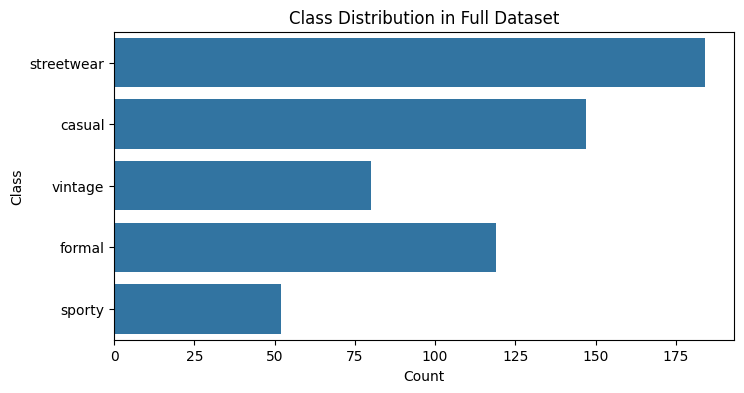

choice
streetwear    184
casual        147
formal        119
vintage        80
sporty         52
Name: count, dtype: int64


In [5]:
# Print class distribution and visualize class balance to check for imbalance
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
sns.countplot(y=df_full['choice'])  # Visualize class counts
plt.title('Class Distribution in Full Dataset')
plt.xlabel('Count')
plt.ylabel('Class')
plt.show()
print(df_full['choice'].value_counts())  # Print class counts

## Visualize class distribution
This cell visualizes the distribution of style classes in the dataset using a countplot to check for class imbalance.

In [6]:
# Remove rows with missing image files from the full dataset (redundant if already done above, but ensures robustness)
def file_exists(row):
    return os.path.exists(row['image'])  # image path is already fixed above

df_full = df_full[df_full.apply(file_exists, axis=1)].reset_index(drop=True)
print(f"Sample size after removing missing files: {len(df_full)}")

Sample size after removing missing files: 583


## Remove missing image files (redundant check)
This cell ensures that any rows with missing image files are removed from the dataset, even if already done above, for robustness.

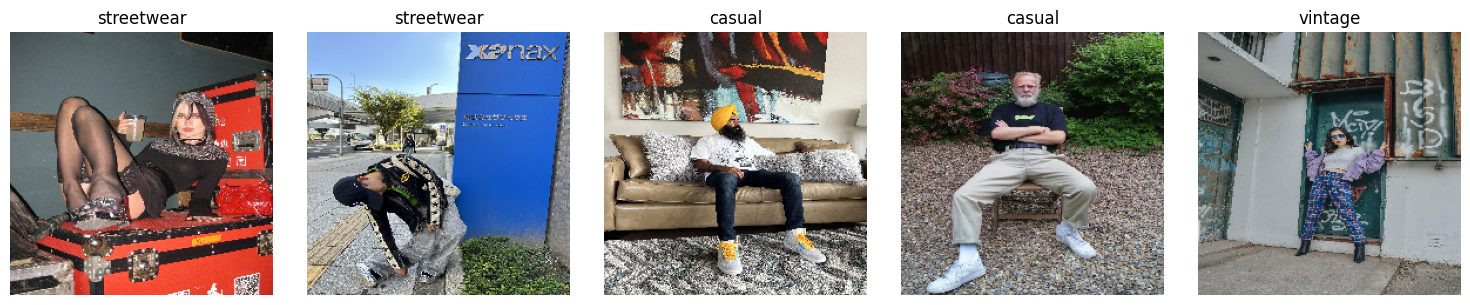

In [7]:
# Load, preprocess, and visualize a few sample images from the full dataset
img_size = (224, 224)  # Standard input size for MobileNetV2

if df_full.empty:
    print("No images to display after filtering missing files.")
else:
    fig, axes = plt.subplots(1, min(5, len(df_full)), figsize=(15, 3))
    for i, (idx, row) in enumerate(df_full.head(5).iterrows()):
        img_path = row['image']  # path is already fixed
        if os.path.exists(img_path):
            img = load_img(img_path, target_size=img_size)  # Load and resize image
            img_arr = img_to_array(img) / 255.0  # Normalize to [0,1]
            axes[i].imshow(img_arr)
            axes[i].set_title(row['choice'])
            axes[i].axis('off')
    plt.tight_layout()
    plt.show()

## Visualize sample images
This cell loads and displays a few sample images from the cleaned dataset for visual inspection.

In [8]:
# Encode labels and split the full data into train and test sets
from sklearn.preprocessing import LabelEncoder

# Remove classes with fewer than 2 samples to avoid stratified split errors
class_counts = df_full['choice'].value_counts()
valid_classes = class_counts[class_counts >= 2].index
df_full_filtered = df_full[df_full['choice'].isin(valid_classes)].reset_index(drop=True)

if df_full_filtered.empty:
    print("No valid classes with at least 2 samples. Please check your dataset.")
    train_df = pd.DataFrame()
    test_df = pd.DataFrame()
    le = LabelEncoder()
else:
    le = LabelEncoder()
    df_full_filtered['label'] = le.fit_transform(df_full_filtered['choice'])  # Encode class labels as integers
    # Stratified split to maintain class proportions
    train_df, test_df = train_test_split(df_full_filtered, test_size=0.3, stratify=df_full_filtered['label'], random_state=42)
    print('Train size:', len(train_df), 'Test size:', len(test_df))
    print('Classes:', le.classes_)

Train size: 407 Test size: 175
Classes: ['casual' 'formal' 'sporty' 'streetwear' 'vintage']


## Encode labels and stratified train-test split
This cell encodes the style labels as integers and splits the data into stratified train and test sets, ensuring class proportions are maintained.

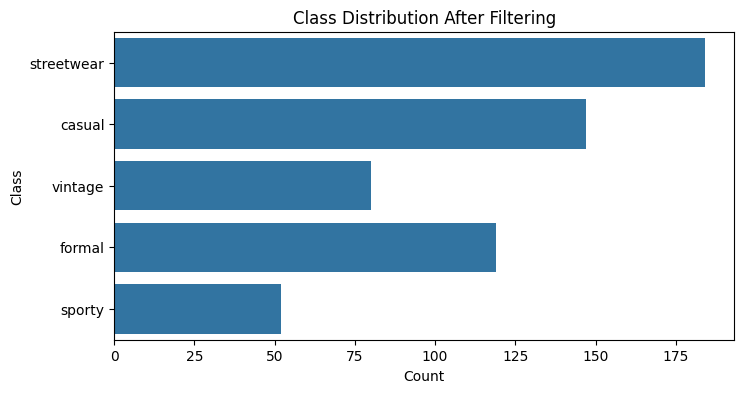

choice
streetwear    184
casual        147
formal        119
vintage        80
sporty         52
Name: count, dtype: int64
Class weights: {0: 0.7918367346938775, 1: 0.9781512605042016, 2: 2.2384615384615385, 3: 0.6326086956521739, 4: 1.455}


In [9]:
# Visualize class distribution after filtering and compute class weights for imbalanced classes
import seaborn as sns
from sklearn.utils.class_weight import compute_class_weight

if not df_full_filtered.empty:
    plt.figure(figsize=(8,4))
    sns.countplot(y=df_full_filtered['choice'])  # Visualize class counts after filtering
    plt.title('Class Distribution After Filtering')
    plt.xlabel('Count')
    plt.ylabel('Class')
    plt.show()
    print(df_full_filtered['choice'].value_counts())

    # Compute class weights for imbalanced classes (helps CNN training)
    class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(df_full_filtered['label']), y=df_full_filtered['label'])
    class_weights_dict = {i : w for i, w in enumerate(class_weights)}
    print('Class weights:', class_weights_dict)
else:
    class_weights_dict = None

## Visualize class distribution after filtering and compute class weights
This cell visualizes the class distribution after filtering and computes class weights to address class imbalance for the CNN model.

In [10]:
# Create data generators for training and testing with advanced augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalize pixel values
    horizontal_flip=True,  # Randomly flip images horizontally
    vertical_flip=True,  # Randomly flip images vertically
    rotation_range=40,  # Randomly rotate images
    width_shift_range=0.2,  # Randomly shift images horizontally
    height_shift_range=0.2,  # Randomly shift images vertically
    zoom_range=0.3,  # Randomly zoom images
    brightness_range=[0.6,1.4],  # Randomly change brightness
    shear_range=0.2,  # Shear transformation
    channel_shift_range=30.0,  # Randomly shift color channels
    fill_mode='nearest',  # Fill in missing pixels after transformation
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input  # Preprocess for MobileNetV2
    )
test_datagen = ImageDataGenerator(rescale=1./255, preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input)

def dataframe_to_generator(df, datagen, batch_size=4):
    # Converts a DataFrame of image paths and labels into a Keras data generator
    if df.empty or 'image' not in df.columns or 'label' not in df.columns:
        return None
    paths = df['image'].values
    labels = df['label'].values
    imgs = []
    valid_labels = []
    for p, label in zip(paths, labels):
        try:
            img = img_to_array(load_img(p, target_size=img_size))
            imgs.append(img)
            valid_labels.append(label)
        except Exception as e:
            print(f"Warning: Could not load image {p}: {e}")
    if not imgs:
        return None
    imgs = np.array(imgs)
    return datagen.flow(imgs, to_categorical(valid_labels, num_classes=len(le.classes_)), batch_size=batch_size)

train_gen = dataframe_to_generator(train_df, train_datagen) if not train_df.empty else None
test_gen = dataframe_to_generator(test_df, test_datagen) if not test_df.empty else None

## Create data generators with augmentation
This cell creates Keras data generators for training and testing, applying advanced augmentation to the training set to improve generalization.

In [11]:
# Build a transfer learning model using MobileNetV2 with fine-tuning and callbacks for better accuracy
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

if train_gen is None or test_gen is None or train_df.empty or test_df.empty:
    print("No data available for training or testing. Please check your dataset and preprocessing steps.")
    model = None
else:
    # Clear any previous session to avoid clutter from old models/layers
    tf.keras.backend.clear_session()

    # Use MobileNetV2 as the base model (pre-trained on ImageNet)
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    base_model.trainable = False  # Freeze base model layers for initial training

    # Add custom classification head for our dataset
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    predictions = Dense(len(le.classes_), activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)

    # Compile the model with Adam optimizer and categorical crossentropy loss
    model.compile(optimizer=Adam(learning_rate=0.0005), loss='categorical_crossentropy', metrics=['accuracy'])
    model.summary()

    # Callbacks for early stopping, best model saving, and learning rate reduction
    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)

    # Train initial model with class weights if available
    steps_per_epoch = max(1, len(train_df) // 4)
    validation_steps = max(1, len(test_df) // 4)
    history = model.fit(
        train_gen,
        steps_per_epoch=steps_per_epoch,
        epochs=30,
        validation_data=test_gen,
        validation_steps=validation_steps,
        callbacks=[early_stop, checkpoint, reduce_lr],
        class_weight=class_weights_dict if class_weights_dict is not None else None
    )

    # Unfreeze more layers for fine-tuning (e.g., last 50 layers)
    base_model.trainable = True
    for layer in base_model.layers[:-50]:
        layer.trainable = False

    # Re-compile with lower learning rate for fine-tuning
    model.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

    # Fine-tune the model for additional epochs
    history_finetune = model.fit(
        train_gen,
        steps_per_epoch=steps_per_epoch,
        epochs=15,
        validation_data=test_gen,
        validation_steps=validation_steps,
        callbacks=[early_stop, checkpoint, reduce_lr],
        class_weight=class_weights_dict if class_weights_dict is not None else None
    )

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,422,597 (9.24 MB)

 Trainable params: 164,613 (643.02 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Epoch 1/30


b:\BHT Study\SEM 2\Data Science WorkflowApplications 2\project\Fashion Style Classifier\venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.1949 - loss: 1.7608

101/101 ━━━━━━━━━━━━━━━━━━━━ 15s 97ms/step - accuracy: 0.1947 - loss: 1.7608 - val_accuracy: 0.0930 - val_loss: 1.7434 - learning_rate: 5.0000e-04
Epoch 2/30
Epoch 2/30
  1/101 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.2500 - loss: 1.7550

b:\BHT Study\SEM 2\Data Science WorkflowApplications 2\project\Fashion Style Classifier\venv\Lib\site-packages\keras\src\trainers\epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


101/101 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.2500 - loss: 1.7550 - val_accuracy: 0.0930 - val_loss: 1.8052 - learning_rate: 5.0000e-04
Epoch 3/30
Epoch 3/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 8s 80ms/step - accuracy: 0.1738 - loss: 1.6881 - val_accuracy: 0.0930 - val_loss: 2.0037 - learning_rate: 5.0000e-04
Epoch 4/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 8s 80ms/step - accuracy: 0.1738 - loss: 1.6881 - val_accuracy: 0.0930 - val_loss: 2.0037 - learning_rate: 5.0000e-04
Epoch 4/30
  1/101 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.5000 - loss: 1.9320
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
101/101 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.5000 - loss: 1.9320 - val_accuracy: 0.0930 - val_loss: 2.0993 - learning_rate: 5.0000e-04
Epoch 5/30

Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
101/101 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.5000 - loss: 1.9320 - val_accuracy: 0.0930 - val_loss: 2.0993 - learning_rat

101/101 ━━━━━━━━━━━━━━━━━━━━ 8s 81ms/step - accuracy: 0.1233 - loss: 1.7423 - val_accuracy: 0.0930 - val_loss: 1.7138 - learning_rate: 2.5000e-04
Epoch 6/30
Epoch 6/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.2500 - loss: 1.9746 - val_accuracy: 0.0930 - val_loss: 1.7354 - learning_rate: 2.5000e-04
Epoch 7/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.2500 - loss: 1.9746 - val_accuracy: 0.0930 - val_loss: 1.7354 - learning_rate: 2.5000e-04
Epoch 7/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.1778 - loss: 1.7011

101/101 ━━━━━━━━━━━━━━━━━━━━ 8s 79ms/step - accuracy: 0.1781 - loss: 1.7005 - val_accuracy: 0.3198 - val_loss: 1.5930 - learning_rate: 2.5000e-04
Epoch 8/30
Epoch 8/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.2500 - loss: 1.5742 - val_accuracy: 0.3198 - val_loss: 1.5959 - learning_rate: 2.5000e-04
Epoch 9/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.2500 - loss: 1.5742 - val_accuracy: 0.3198 - val_loss: 1.5959 - learning_rate: 2.5000e-04
Epoch 9/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 8s 78ms/step - accuracy: 0.1361 - loss: 1.6979 - val_accuracy: 0.1395 - val_loss: 1.6108 - learning_rate: 2.5000e-04
Epoch 10/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 8s 78ms/step - accuracy: 0.1361 - loss: 1.6979 - val_accuracy: 0.1395 - val_loss: 1.6108 - learning_rate: 2.5000e-04
Epoch 10/30
  1/101 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.5000 - loss: 1.6303
Epoch 10: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
101/101 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accur

## Build and train CNN model (MobileNetV2 with transfer learning and fine-tuning)
This cell builds the CNN model using MobileNetV2, trains it with transfer learning, and then fine-tunes the last layers for better accuracy.

In [ ]:
# (Optional) Simple training block for quick runs or debugging
if train_gen is None or test_gen is None:
    print("No data available for training or testing. Please check your dataset and preprocessing steps.")
else:
    steps_per_epoch = max(1, len(train_df) // 4)
    validation_steps = max(1, len(test_df) // 4)
    history = model.fit(
        train_gen,
        steps_per_epoch=steps_per_epoch,
        epochs=5,
        validation_data=test_gen,
        validation_steps=validation_steps
    )

Epoch 1/5
101/101 ━━━━━━━━━━━━━━━━━━━━ 16s 105ms/step - accuracy: 0.3036 - loss: 1.5546 - val_accuracy: 0.2558 - val_loss: 1.6243
Epoch 2/5
101/101 ━━━━━━━━━━━━━━━━━━━━ 16s 105ms/step - accuracy: 0.3036 - loss: 1.5546 - val_accuracy: 0.2558 - val_loss: 1.6243
Epoch 2/5
101/101 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.2500 - loss: 1.5510 - val_accuracy: 0.2616 - val_loss: 1.6193
Epoch 3/5
101/101 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.2500 - loss: 1.5510 - val_accuracy: 0.2616 - val_loss: 1.6193
Epoch 3/5
  8/101 ━━━━━━━━━━━━━━━━━━━━ 8s 86ms/step - accuracy: 0.3199 - loss: 1.5483

## (Optional) Simple training block
This cell provides a simple training block for quick runs or debugging, using fewer epochs and no callbacks.

In [ ]:
# Evaluate the model and show predictions on a few test images
import random

if test_df.empty or 'model' not in globals():
    print("No test data or model not defined. Please check previous steps.")
else:
    test_imgs = test_df.sample(n=min(10, len(test_df)), random_state=42)
    for idx, row in test_imgs.iterrows():
        img_path = row['image']  # path is already correct
        try:
            img = load_img(img_path, target_size=img_size)
            img_arr = img_to_array(img) / 255.0
            pred = model.predict(np.expand_dims(img_arr, axis=0))
            pred_label = le.inverse_transform([np.argmax(pred)])[0]
            plt.imshow(img_arr)
            plt.title(f"True: {row['choice']} | Pred: {pred_label}")
            plt.axis('off')
            plt.show()
        except Exception as e:
            print(f"Warning: Could not load image {img_path}: {e}")

## Evaluate model and visualize predictions
This cell evaluates the trained CNN model on a few test images and visualizes the predictions alongside the true labels.

In [ ]:
# Print classification metrics for the test set (accuracy, precision, recall, F1-score)
from sklearn.metrics import classification_report

if test_df.empty or 'model' not in globals():
    print("No test data or model not defined. Please check previous steps.")
else:
    # Prepare test data
    y_true = test_df['label'].values
    imgs = []
    for img_path in test_df['image']:
        img = img_to_array(load_img(img_path, target_size=img_size)) / 255.0
        imgs.append(img)
    X_test = np.array(imgs)
    y_pred = model.predict(X_test)
    y_pred_labels = np.argmax(y_pred, axis=1)
    print(classification_report(y_true, y_pred_labels, target_names=le.classes_))

## Results summary
After running the notebook, fill in your actual results here. For example: 'CNN (MobileNetV2): Accuracy = 0.85, Precision = 0.84, Recall = 0.83, F1-score = 0.83'.